## Preparation

In [ ]:
!pip install transformers
!pip install efficientnet_pytorch

     |████████████████████████████████| 2.3MB 7.0MB/s 
     |████████████████████████████████| 901kB 40.0MB/s 
     |████████████████████████████████| 3.3MB 39.8MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=bc8cbdd9ff3dbf03f6bc04ae3af28fb24f783855c07b6c371214819abfa9f9a1
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
import os
import time
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import nn
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from numpy import printoptions
import requests
import tarfile
import random
import json
from shutil import copyfile
import torch.nn.functional as F
import transformers
from transformers import AutoModel, AlbertTokenizer,AlbertForSequenceClassification
from efficientnet_pytorch import EfficientNet

In [ ]:
# Fix all seeds to make experiments reproducible
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
torch.backends.cudnn.deterministic = True

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### load and process dataset

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = '1243XACf-GxdGc4GV__MY-BWWV3a7xK5I'  # Restricted shared link

downloaded = drive.CreateFile({'id':link}) 
downloaded.GetContentFile('2021s1comp5329assignment2.zip')

!unzip 2021s1comp5329assignment2.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: COMP5329S1A2Dataset/data/550.jpg  
  inflating: COMP5329S1A2Dataset/data/5500.jpg  
  inflating: COMP5329S1A2Dataset/data/5501.jpg  
  inflating: COMP5329S1A2Dataset/data/5502.jpg  
  inflating: COMP5329S1A2Dataset/data/5503.jpg  
  inflating: COMP5329S1A2Dataset/data/5504.jpg  
  inflating: COMP5329S1A2Dataset/data/5505.jpg  
  inflating: COMP5329S1A2Dataset/data/5506.jpg  
  inflating: COMP5329S1A2Dataset/data/5507.jpg  
  inflating: COMP5329S1A2Dataset/data/5508.jpg  
  inflating: COMP5329S1A2Dataset/data/5509.jpg  
  inflating: COMP5329S1A2Dataset/data/551.jpg  
  inflating: COMP5329S1A2Dataset/data/5510.jpg  
  inflating: COMP5329S1A2Dataset/data/5511.jpg  
  inflating: COMP5329S1A2Dataset/data/5512.jpg  
  inflating: COMP5329S1A2Dataset/data/5513.jpg  
  inflating: COMP5329S1A2Dataset/data/5514.jpg  
  inflating: COMP5329S1A2Dataset/data/5515.jpg  
  inflating: COMP5329S1A2Dataset/data/5516.jpg  
  inflating: COMP5329S1A2Dataset/data/5517.j

In [ ]:
import re
import pandas as pd
from io import StringIO
FILENAME_TRAIN = '/content/COMP5329S1A2Dataset/train.csv'
FILENAME_TEST = '/content/COMP5329S1A2Dataset/test.csv'

## Process Text

#### deal with lines cannot be read

In [ ]:
with open(FILENAME_TRAIN) as fp:
    # read a list of lines into data
    data = fp.readlines()

data[4790] = data[4790].replace("/", "")
data[14716] = data[14716].replace("/", "")
data[14961] = data[14961].replace("/", "")
data[29895] = data[29895].replace("/", "")

# and write everything back
with open(FILENAME_TRAIN, 'w') as file:
    file.writelines(data)

#### load data to dataframe

In [ ]:
with open(FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train_origin = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

#### remove all "

In [ ]:
df_train_origin = df_train_origin.drop(columns = 'Caption').join(df_train_origin['Caption'].str.replace('\"', ''))
df_test = df_test.drop(columns = 'Caption').join(df_test['Caption'].str.replace('\"', ''))

### Prepare text

#### Get Corpus

In [ ]:
whole_sentences = pd.concat([df_train_origin['Caption'], df_test['Caption']], axis=0, ignore_index=True)

#### Load Pre-trained Word Embedding Model

In [ ]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords as sw
# stop_words = sw.words()
STOPWORDS = set(sw.words('english'))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# import gensim.downloader as api
# word_emb_model = api.load("glove-twitter-25") # Download an embedding other than glove-twitter-50

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#### Define `prepare_text` Function

In [ ]:
def prepare_text(sentences): # string to pure word
    prepared_sents = []
    for text in sentences:
        # print(text)
        text = text.lower() # lowercase
        text = re.sub(r'[^A-Za-z]+', ' ', text) # remove symbols / digits
        # text = re.sub(r'[0-9]','',text)
        pure_text = []
        for item in text.split():
            if item not in STOPWORDS: # remove stopword
                pure_text.append(item)

        text_le = [lemmatizer.lemmatize(word) for word in pure_text] # lammatisation

        # token = [word_tokenize(word) for word in text_le]
        prepared_sents.append(text_le)
    return prepared_sents

#### Get Max Len

In [ ]:
max_seq_len = max(len(s) for s in prepare_text(whole_sentences))
max_seq_len

28

#### Make `word_index` and `word_list`

In [ ]:
# processed_whole_sents = prepare_text(whole_sentences)
# vocab_list = []
# for sent in processed_whole_sents:
#     for word in sent:
#         vocab_list.append(word)
# # Create the Embedding lookup table
# import numpy as np
# # emb_dim = word_emb_model.vector_size
# word_set = set()
# min_freq = 4
# from collections import Counter
# c = Counter(vocab_list)
# for i in c:
#     if c[i] >= min_freq:
#         word_set.add(i)
# word_set.add('[PAD]')
# word_set.add('[UNKOWN]')
# word_list=list(word_set)
# word_list.sort()
# emb_table = []
# word_index = {}
# emb_table = []
# for i, word in enumerate(word_list):
#     word_index[word] = i

# len(word_index),len(emb_table)

#### Word Embedding

In [ ]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))
# Download the "glove-twitter-25" embeddings
word_emb_model = gensim.downloader.load('word2vec-google-news-300') # 1662.8MB

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
processed_whole_sents = prepare_text(whole_sentences)
processed_whole_sents[1]

['couple', 'men', 'riding', 'horse', 'top', 'green', 'field']

In [ ]:
vocab_list = []
for sent in processed_whole_sents:
    for word in sent:
        vocab_list.append(word)

In [ ]:
# Create the Embedding lookup table
import numpy as np
emb_dim = word_emb_model.vector_size
word_set = set()
min_freq = 5
from collections import Counter
c = Counter(vocab_list)
for i in c:
    if c[i] >= min_freq:
        word_set.add(i)
word_set.add('[PAD]')
word_set.add('[UNKOWN]')
word_list=list(word_set)
word_list.sort()
emb_table = []
word_index = {}
emb_table = []
for i, word in enumerate(word_list):
    word_index[word] = i
    if word in word_emb_model:
        emb_table.append(word_emb_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)
    
print(emb_table)
emb_table.shape

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.17480469  0.17871094  0.09082031 ...  0.07568359 -0.11181641
  -0.0625    ]
 ...
 [-0.08544922 -0.10253906 -0.48632812 ...  0.02075195  0.08496094
   0.00061035]
 [-0.07421875 -0.10205078  0.20117188 ... -0.25390625  0.06054688
  -0.21289062]
 [-0.04248047  0.16015625 -0.2265625  ...  0.18945312 -0.00692749
   0.1328125 ]]


(2218, 300)

### split into train set and validation set

In [ ]:
df_train = df_train_origin
df_val = df_train[24000:] # 6000 samples for evaluation
df_train = df_train[:24000] # 24000 samples for train

In [ ]:
# save splitted train file
df_train.to_csv("/content/COMP5329S1A2Dataset/train_split.csv", index=False)
df_train

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
...,...,...,...
23995,23995.jpg,1,A group of people floating on top of waves in ...
23996,23996.jpg,1,A man wearing an orange tie and a woman wearin...
23997,23997.jpg,1 10 3 6,A large sign is lit up on a dark city street.
23998,23998.jpg,1 15,children learning to play tennis on a clay court


In [ ]:
# save splitted val file
df_val.to_csv("/content/COMP5329S1A2Dataset/val_split.csv", index=False)
df_val

,ImageID,Labels,Caption
24000,24000.jpg,1,A young girl walking on a road carrying an umb...
24001,24001.jpg,1,A woman with a large black purse holding an um...
24002,24002.jpg,1,Two kids play over a soccer ball during a game.
24003,24003.jpg,1,A man standing and cutting food at a counter.
24004,24004.jpg,5,A plane is at the airport preparing to take off.
...,...,...,...
29995,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
29996,29996.jpg,1,A plate topped with a pizza being cut with a s...
29997,29997.jpg,1,A man riding a snowboard on top of snow.
29998,29998.jpg,1,This photo shows people skiing in the mountains.


### get label information

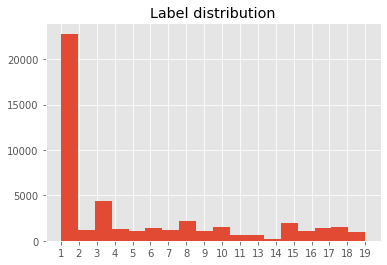

In [ ]:
# Label distribution
import matplotlib.pyplot as plt
label_list = []

for i in df_train_origin['Labels']:
    label_list.extend(i.split())
label_list = sorted([int(i) for i in label_list])
label_list = [str(i) for i in label_list]

plt.style.use('ggplot')
plt.title("Label distribution")
plt.hist(label_list, bins=18)
plt.show()

In [ ]:
# create a label set
label_set = set(label_list)
label_set = sorted([int(i) for i in label_set])
label_set

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
# number of class
N_CLASS = len(label_set)
N_CLASS

18

## OOP Classes and Functions

In [ ]:
# dependency
import os
import time
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import nn
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from numpy import printoptions
import requests
import tarfile
import random
import json
from shutil import copyfile

#### Tokenizer

In [ ]:
class A2Tokenizer:
    def __init__(self):
        pass
    def tokenize(self, sentences, seq_len, word_index):
        sentences = prepare_text(sentences)
        sent_encoded = []
        for sent in sentences:
            temp_encoded = [word_index[word] if word in word_index else word_index['[UNKOWN]'] for word in sent]
            if len(temp_encoded) < seq_len:
                temp_encoded += [word_index['[PAD]']] * (seq_len - len(temp_encoded))
            else:
                temp_encoded = temp_encoded[:seq_len]
            sent_encoded.append(temp_encoded)
        return sent_encoded

### Text model

#### Bi-LSTM

In [ ]:
vocab_size = emb_table.shape[0]
emb_dim = emb_table.shape[1]

In [ ]:
class Bi_LSTM_Emb(nn.Module):
    def __init__(self,n_classes):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_classes)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n,c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return self.sigm(z)

### Image Model

#### Resnext50

In [ ]:
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

#### A2EfficientNet

In [ ]:
class A2EfficientNet(nn.Module):
    def __init__(self, n_classes=18):
        super().__init__()
        EN = EfficientNet.from_pretrained('efficientnet-b4')
        EN._fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features = EN._fc.in_features, out_features = n_classes)
        )
        self.base_model = EN
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

### A2CombinedModel

In [ ]:
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
class A2CombinedModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bilstm = Bi_LSTM(n_classes)

        self.sigm = nn.Sigmoid()
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=n_classes*2, out_features=n_classes)
        )

    def forward(self, img_features, captions):
        img_features = img_features.squeeze(-1)
        img_features = img_features.squeeze(-1)
        caption_features = self.bilstm(captions)
        logits_concat = torch.cat((img_features, caption_features),1)
        return self.sigm(self.classifier(logits_concat))

### A2Dataset

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = set(sw.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def prepare_text(sentences): # string to pure word
    prepared_sents = []
    for text in sentences:
        text = text.lower() # lowercase
        text = re.sub(r'[^A-Za-z]+', ' ', text) # remove symbols / digits
        # text = re.sub(r'[0-9]','',text)
        pure_text = []
        for item in text.split():
            if item not in STOPWORDS: # remove stopword
                pure_text.append(item)

        text_le = [lemmatizer.lemmatize(word) for word in pure_text] # lemmatizer
        prepared_sents.append(text_le)
    return prepared_sents

def prepare_text_one(sentence): # string to pure word
    sentence = sentence.lower() # lowercase
    sentence = re.sub(r'[^A-Za-z]+', ' ', sentence) # remove symbols / digits
    # text = re.sub(r'[0-9]','',text)
    pure_sentence = []
    for item in sentence.split():
        if item not in STOPWORDS: # remove stopword
            pure_sentence.append(item)

    sentence_le = [lemmatizer.lemmatize(word) for word in pure_sentence] # lemmatisation
    return sentence_le

# Simple dataloader and label binarization, that is converting test labels into binary arrays of length 18 (number of classes) with 1 in places of applicable labels).
class A2Dataset(Dataset):
    def __init__(self, data_path, type, transforms=None):
        # data_path: the root path of dataset
        # type: dataset type, one of ['train', 'test', 'val', 'whole'], where 'whole' means the whole training set without splitting
        # transforms: img tranfroms
        self.transforms = transforms
        # self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
        self.type = type
        self.data_path = data_path
        if self.type == 'train':
            file_path = os.path.join(data_path, 'train_split.csv')
        elif self.type == 'test':
            file_path = os.path.join(data_path, 'test.csv')
        elif self.type == 'val':
            file_path = os.path.join(data_path, 'val_split.csv')
        elif self.type == 'whole':
            file_path = os.path.join(data_path, 'train.csv')
        with open(file_path) as file:
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
            df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
        self.samples = df
        
        if self.type != "test":
            label_set = []
            for i in self.samples["Labels"]:
                label_set.extend(i.split())
            label_set = set(label_set)
            label_set = sorted([int(i) for i in label_set])

            self.imgs = []
            self.labels = []
            for index, row in self.samples.iterrows():
                self.imgs.append(row['ImageID'])
                self.labels.append(row['Labels'])

            self.classes = label_set
            self.labels = self.samples['Labels']
            self.caption = self.samples['Caption']
            self.img_id = self.samples['ImageID']


            for item_id in range(len(self.labels)):
                item = self.labels[item_id].split()
                vector = [1 if str(cls) in item else 0 for cls in self.classes ]
                self.labels[item_id] = np.array(vector, dtype=float)

        else:
            self.imgs = []
            for index, row in self.samples.iterrows():
                self.imgs.append(row['ImageID'])

            self.caption = self.samples['Caption']
            self.img_id = self.samples['ImageID']
            self.caption = self.samples['Caption']

        print("Loading {} set with {} samples".format(self.type, len(self.imgs)))

    def __getitem__(self, item):
        # process caption
        caption = self.caption[item]
        
        # caption = self.tokenizer.encode_plus(
        #     caption,
        #     None,
        #     add_special_tokens=True,
        #     max_length=28,
        #     pad_to_max_length=True,
        #     return_token_type_ids=True,
        #     truncation=True
        # )
        # ids = caption['input_ids']
        # mask = caption['attention_mask']
        # token_type_ids = caption["token_type_ids"]


        # process img and target
        if self.type != "test":
            target =  torch.tensor(self.labels[item], dtype=torch.float)
            img_path = os.path.join(self.data_path, 'data', self.samples['ImageID'][item])
            img = Image.open(img_path)
            if self.transforms is not None:
                img = self.transforms(img)
            
            out_data =  {
                # 'ids': torch.tensor(ids, dtype=torch.long),
                # 'mask': torch.tensor(mask, dtype=torch.long),
                # 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'caption': caption,
                'img': img,
                'target': target
            }
            return out_data
        else:
            img_path = os.path.join(self.data_path, 'data', self.samples['ImageID'][item])
            img = Image.open(img_path)
            if self.transforms is not None:
                img = self.transforms(img)
            
            out_data =  {
                # 'ids': torch.tensor(ids, dtype=torch.long),
                # 'mask': torch.tensor(mask, dtype=torch.long),
                # 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'caption': caption,
                'img': img
            }
            return out_data

    def __len__(self):
        return len(self.imgs)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading train set with 24000 samples


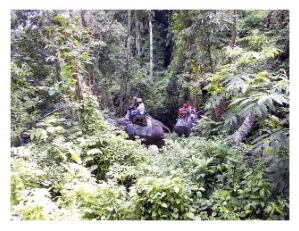

In [ ]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
dataset_train = A2Dataset("/content/COMP5329S1A2Dataset", "train")

# A simple function for visualization.
def show_sample(img, binary_img_labels):
    # Convert the binary labels back to the text representation.    
    try:
        plt.imshow(img)
    except:
        plt.imshow(img.reshape(256,256,-1))
    plt.axis('off')
    plt.show()

show_sample(dataset_train[2]['img'],dataset_train[2]['target'])

### Metrics Function

In [ ]:
# Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return  {
            'f1_score': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

### Checkpoint

In [ ]:
# Here is an auxiliary function for checkpoint saving.
def checkpoint_save(model, save_path, epoch):
    f = os.path.join(save_path, 'checkpoint-{:06d}.pth'.format(epoch))
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
    print('saved checkpoint:', f)

## Main Process

### Define transform

In [ ]:
# define a transform
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Test preprocessing
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
print(tuple(np.array(np.array(mean)*255).tolist()))

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
                            shear=None, resample=False, 
                            fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

(123.675, 116.28, 103.53)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1315: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1329: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


### Define hyper parameters

In [ ]:
# Initialize the training parameters.
num_workers = 4 # Number of CPU processes for data preprocessing
lr = 1e-4 # Learning rate
batch_size = 16
save_freq = 1 # Save checkpoint frequency (epochs)
test_freq = 100 # Test model frequency (iterations)
max_epoch_number = 30 #50 # Number of epochs for training 
# Note: on the small subset of data overfitting happens after 30-35 epochs

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

vocab_size = len(word_list)
emb_dim = 300
n_hidden = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Save path for checkpoints
save_path = 'chekpoints/'

# word embedding
seq_len = max_seq_len

### Define `dataset`

In [ ]:
# Initialize the dataloaders for training.
val_dataset = A2Dataset("/content/COMP5329S1A2Dataset", "val", val_transform)
train_dataset = A2Dataset("/content/COMP5329S1A2Dataset", "train", train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

Loading val set with 6000 samples
Loading train set with 24000 samples


### Define `model` and `tokenizer`

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# link = '1IGN-7LWL2e6Idrg1_Yl9wS_WpjdcEGlZ'  # Restricted shared link

# downloaded = drive.CreateFile({'id':link}) 
# downloaded.GetContentFile('859effnetb4.pth')

link = '1cgZxk3MEsjwQMuxBcM_KrbD9lebEgwWH'  # Restricted shared link

downloaded = drive.CreateFile({'id':link}) 
downloaded.GetContentFile('870EffNetB4.pth')


# link = '1uqTqhNXMwZz4BKdgMHw5WuFzwRn6z2v2'  # Restricted shared link

# downloaded = drive.CreateFile({'id':link}) 
# downloaded.GetContentFile('839Bilstmwe20.pth')


# link = '1gKXGJFjsBRqQU7iR0vkQlHuFRHkh_GxD'  # Restricted shared link

# downloaded = drive.CreateFile({'id':link}) 
# downloaded.GetContentFile('845bilstm.pth')


# link = '1tSAViVn41A0aibozKEHc45rpvyHhgcRe'  # Restricted shared link

# downloaded = drive.CreateFile({'id':link}) 
# downloaded.GetContentFile('847WE27.pth')


link = '18q4Atv3gZOUj_DX6IbcflsbTkX2WuVTF'  # Restricted shared link

downloaded = drive.CreateFile({'id':link}) 
downloaded.GetContentFile('852WE10.pth')

In [ ]:
n_classes = len(train_dataset.classes) # 18

# Initialize the model
cv_model = A2EfficientNet()
weights = torch.load('/content/870EffNetB4.pth')
cv_model.load_state_dict(weights)
for param in cv_model.parameters():
    param.requires_grad=True


nlp_model = Bi_LSTM_Emb(n_classes)
nlp_weights = torch.load('/content/852WE10.pth')
nlp_model.load_state_dict(nlp_weights)
for param in nlp_model.parameters():
    param.requires_grad=True

classifier = nn.Sequential(
    nn.Linear(in_features=36, out_features=2392),
    nn.ReLU(),
    nn.Linear(in_features=2392, out_features=n_classes),
    nn.Sigmoid()
)



# Switch model to GPU.
cv_model = cv_model.to(device)
nlp_model = nlp_model.to(device)
classifier = classifier.to(device)

tokenizer = A2Tokenizer()

Loaded pretrained weights for efficientnet-b4


In [ ]:
# n_cv_model_param = sum([p.numel() for p in cv_model.parameters()]) / 1_000_000
# n_combinedModel_param = sum([p.numel() for p in combined_model.parameters()]) / 1_000_000
# print("Number of parameters: {}M".format(round(n_cv_model_param+n_combinedModel_param,2)))
# print("Model Size: {}MB".format(round((n_cv_model_param+n_combinedModel_param)*4,2)))

### Define `optimizer`

In [ ]:
optimizer = torch.optim.AdamW(classifier.parameters(), lr)
# cv_optimizer = torch.optim.Adam(cv_model.parameters(), lr=lr)

### Define `criterion`

In [ ]:
# Loss function
criterion = nn.BCELoss().to(device)

### Train and Validation

In [ ]:
os.makedirs(save_path, exist_ok=True)
# Run training
epoch = 0
iteration = 0
while True:
    batch_losses = []
    for data in train_dataloader:
        cv_model.train()
        nlp_model.train()
        # prepare image features
        targets = data['target'].to(device)
        imgs = data['img'].to(device)

        # prepare text input
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)

        # get features
        # img_features = cv_model.feature_extract(imgs)
        img_logits = cv_model(imgs)
        nlp_logits = nlp_model(captions)

        # calculate loss
        logits_concat = torch.cat((img_logits, nlp_logits),1)
        combined_model_result = classifier(logits_concat)

        # cv_loss = criterion(nn.Sigmoid(img_logits), targets.type(torch.float))
        loss = criterion(combined_model_result, targets.type(torch.float))
        batch_loss_value = loss.item()

        # backward
        loss.backward()

        # update grad
        optimizer.step()

        optimizer.zero_grad()

        batch_losses.append(batch_loss_value)
        with torch.no_grad():
            result = calculate_metrics(combined_model_result.cpu().numpy(), targets.cpu().numpy())
        if iteration % test_freq == 0:
            with torch.no_grad():
                model_result = []
                targets = []
                
                for data in val_dataloader:
                    
                    cv_model.eval()
                    nlp_model.eval()
                    # prepare image features
                    batch_targets = data['target'].to(device)
                    imgs = data['img'].to(device)

                    # prepare text input
                    captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
                    captions = torch.from_numpy(np.array(captions)).to(device)

                    # get features
                    # img_features = cv_model.feature_extract(imgs)
                    img_logits = cv_model(imgs)
                    nlp_logits = nlp_model(captions)

                    # calculate loss
                    logits_concat = torch.cat((img_logits, nlp_logits),1)
                    model_batch_result = classifier(logits_concat)
                    model_result.extend(model_batch_result.cpu().numpy())

                    targets.extend(batch_targets.cpu().numpy())
            result = calculate_metrics(np.array(model_result), np.array(targets))
            print("epoch:{:2d} iter:{:3d}   Validation: F1 score: {:.3f}".format(epoch, iteration, result['f1_score']))
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
    if epoch % save_freq == 0:
        pass
        checkpoint_save(classifier, save_path, epoch)
    epoch += 1
    if max_epoch_number < epoch:
        break

epoch: 0 iter:  0   Validation: F1 score: 0.164
epoch: 0 iter:100   Validation: F1 score: 0.631
epoch: 0 iter:200   Validation: F1 score: 0.632
epoch: 0 iter:300   Validation: F1 score: 0.632
epoch: 0 iter:400   Validation: F1 score: 0.632
epoch: 0 iter:500   Validation: F1 score: 0.632
epoch: 0 iter:600   Validation: F1 score: 0.632
epoch: 0 iter:700   Validation: F1 score: 0.632
epoch: 0 iter:800   Validation: F1 score: 0.632
epoch: 0 iter:900   Validation: F1 score: 0.632
epoch: 0 iter:1000   Validation: F1 score: 0.632
epoch: 0 iter:1100   Validation: F1 score: 0.636
epoch: 0 iter:1200   Validation: F1 score: 0.641
epoch: 0 iter:1300   Validation: F1 score: 0.643
epoch: 0 iter:1400   Validation: F1 score: 0.645
epoch: 0 iter:1500 train: loss:0.274
saved checkpoint: chekpoints/checkpoint-000000.pth
epoch: 1 iter:1500   Validation: F1 score: 0.646
epoch: 1 iter:1600   Validation: F1 score: 0.647
epoch: 1 iter:1700   Validation: F1 score: 0.645
epoch: 1 iter:1800   Validation: F1 scor

KeyboardInterrupt: ignored